# Temas más relevantes en las reseñas
En este notebook se construye la solución de NLP para identificar cuáles son los temas más abordados, y por tanto los de mayor interés, para la comunidad.

Para este análisis solo se trabajará con el **dataset** de ratings ('books_rating.csv') el cual contiene todas las reseñas de los libros.

### Modelado de temas con LDA
Para realizar este proceso, se utilizará el **modelado de temas con Latent Dirichlet Allocation (LDA)**

Referencia: "Python Machine Learning: Aprendizaje automático y aprendizaje profundo  con Python, scikit-learn y Tensorflow"

> **Disclaimer**

> Debido a que el laboratorio de AWS dejó de estar disponible, la base de datos donde se habpian cargado todos los datos a partir de los cuales se iba a trabajar también dejó de estar disponible. Por esta razón en este notebook se trabajará directamente con los dataset (CSV) originales.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords

# Step 1: Análisis de los datos y limpieza de los datos
Se identifican los dataset, se cargan en memoria, se entiende qué tipo de datos hay y con cuáles realmente vamos a trabajar. En definitiva, se construye un Data Frame de Pandas con toda la información base, a partir de la cual se realizará la selección de una muestra aleatoria para desarrollar todo el análisis.

In [3]:
path = '../../Datasets/books_rating.csv'
df = pd.read_csv(path)
print(df.columns)

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


Se va a trabajar solamente con las columnas de reseñas y score. Se renombran a 'review' y 'score' para hacer más entendible. 

In [4]:
df = df[['review/text', 'review/score']]
colum_ranames = {
    "review/text": "review",
    "review/score": "score"
}
df = df.rename(columns = colum_ranames)

Revisión de nulos en el data frame:

In [5]:
df.isna().sum()

review    8
score     0
dtype: int64

Teniendo en cuenta que la cantidad de nulos es muy baja (casi despresible), se eliminan esos registros que contienen nulos.

In [6]:
df = df.dropna()
df.isna().sum()


review    0
score     0
dtype: int64

# Step 2: Selección de la muestra aleatoria
Teniendo el dataset con las columnas con las que se va a trabajar, se procede a elegir la muestra aleatoria (en principio el 10%). 

Se cara una muestra de los datos (en este caso trabajaremos con el 10% del total, lo que hace que estemos abordando 300.000 registros y un total de 286MB de información en memoria)

Para que la muestra aleatoria no haya que volver a computarla (lo que es computacionalmente costosa, dado a que hay que cargar todo el dataset original), se crea un nuevo CSV con la muestra seleccionada.

In [7]:

percent_sample = 0.1
num_filas_seleccion = int(len(df) * percent_sample)
df = df.sample(n=num_filas_seleccion)

path_new_df = path = '../../Datasets/books_rating_sample.csv'
df.to_csv(path_new_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299999 entries, 1871806 to 1413080
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   review  299999 non-null  object 
 1   score   299999 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.9+ MB


# Step 3: Generar nuevas columnas con información de análisis
Para facilitar el análisis de las reseñas, en términos de "reseñas positivas" y "reseñas negativas", se genera una nueva columna para indicar justamente eso, paerrtiendo del valor del score.

- Positiva: score mayor o igual a 4
- Neutral: score igual a 3
- Negativa: score menor a 3

In [8]:
condiciones = [
    df['score'] >= 4,
    df['score'] == 3,
    df['score'] < 3
]
categorias = ['positiva', 'neutra', 'negativa']
df['category'] = np.select(condiciones, categorias)
agrupado = df.groupby('category').size().reset_index(name='count')
print(agrupado)

   category   count
0  negativa   35310
1    neutra   25357
2  positiva  239332


A continuación se analiza cómo se distribuyen las opiniones según su categoría (y el score)

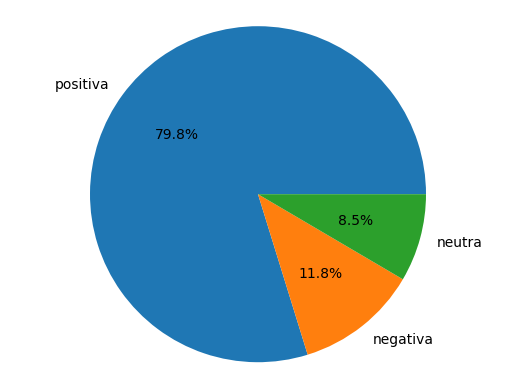

In [9]:
conteos = df['category'].value_counts()
valores = conteos.values
etiquetas = conteos.index
plt.pie(valores, labels = etiquetas, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Ahora vamos a limpiar las reviews limpiando los textos de las reseñas, eliminando caracteres especiales, convirtiendo a minúsculas, y eliminando palabras vacías (stopwords)

In [10]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
reviews = df['review']
reviews = reviews.str.lower().replace('[^a-zA-Z]', ' ', regex=True)
reviews = reviews.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /Users/jorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 4: Modelado de topics con LDA


Lo primero que vamos hacer es construir el modelo de "bolsa de palabras" que se construirá a partir de la tokenización con 'ConunterVectorizer' y con las stop-words en inglés.

Algunos aspectos a tener en cuenta (**configuración de hiperparámetros**):
- Vamos a trabajar con todo el data frame: ```max_df=0.95```, indicando el 95% del data frame
- Limitar a máximo de 1000 palabras que aparecen con mayor frecuencia (inicialmente) ```max_feature=500```

In [20]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=5000)
review_vectors = count_vectorizer.fit_transform(reviews)
feature_names = list(count_vectorizer.vocabulary_.keys())

Ahora entrenaremos el modelo LDA:

In [21]:
n_topics = 5 
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(review_vectors)

LatentDirichletAllocation(n_components=5, random_state=42)

Teniendo definidos los temas, se asignan a cada una de las reseñas.

In [25]:
n_top_words = 10  # Número de palabras a mostrar por tema
topic_assignments = lda.transform(review_vectors)
df['topic'] = topic_assignments.argmax(axis=1)

Ahora para cada tema, muestra las palabras más representativas:

In [35]:
for topic_idx, topic in enumerate(lda.components_):
    topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {' '.join(topic_words)}")

Topic 0: peaceful bennet tedious signs afterwards hold garden piano terrorist murders
Topic 1: tedious sooner afterwards killing cover fitzgerald recovery checking avoid regard
Topic 2: tedious scary afterwards considerable murders recovery limited condition killing candy
Topic 3: afterwards tedious football couples enter peaceful north regard gap saint
Topic 4: tedious bennet afterwards storyline scary learns garden limited sooner mass


Para entender cómo se distribuyen los temas por todas las reseñas, se constriye un gráfico de 'pie' con los porcentajes reflejados de acuerdo con la cantidad de reseñas por tema.

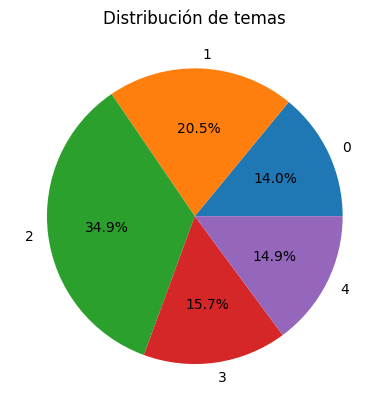

In [32]:
df_grouped = df.groupby('topic').size()
fig, ax = plt.subplots()
ax.pie(df_grouped, labels=df_grouped.index, autopct='%1.1f%%')
ax.set_title('Distribución de temas')
plt.show()

# Step 5: I

In [ ]:
De manera que ahora podemos saber cuáles son las palabras más frecuentes en las reviews negativas, y que no son usadas en reviews positivas.